In [1]:
import wikipedia
import os
from tqdm import tqdm

In [2]:
def extract_data(theme_name) :
    temp_name = theme_name.replace(' ','_')
    dirs = f'./{temp_name}_data'
    if not os.path.isdir(dirs) :
        os.mkdir(dirs)
    results = wikipedia.search(theme_name,results = 1000)
    for index,result in tqdm(enumerate(results)):
        try :
            page = wikipedia.page(result)
            content = page.content
            with open(os.path.join(dirs,f'{index}.txt'),'w+') as f :
                f.write(content)
        except :
            continue

In [3]:
from bs4 import BeautifulSoup
import spacy
import unidecode
from word2number import w2n
import contractions

nlp = spacy.load('en_core_web_md')

# exclude words from spacy stopwords list
deselect_stop_words = []
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False


def strip_html_tags(text):
    """remove html tags from text"""
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")
    return stripped_text


def remove_whitespace(text):
    """remove extra whitespaces from text"""
    text = text.strip()
    return " ".join(text.split())


def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text


def expand_contractions(text):
    """expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text


def text_preprocessing(text, accented_chars=True, contractions=True, 
                       convert_num=True, extra_whitespace=True, 
                       lemmatization=True, lowercase=True, punctuations=True,
                       remove_html=False, remove_num=False, special_chars=True, 
                       stop_words=True):
    """preprocess text with default option set to true for all steps"""
    if remove_html == True: #remove html tags
        text = strip_html_tags(text)
    if extra_whitespace == True: #remove extra whitespaces
        text = remove_whitespace(text)
    if accented_chars == True: #remove accented characters
        text = remove_accented_chars(text)
    if contractions == True: #expand contractions
        text = expand_contractions(text)
    if lowercase == True: #convert all characters to lowercase
        text = text.lower()

    doc = nlp(text) #tokenise text

    clean_text = []
    
    for token in doc:
        flag = True
        edit = token.text
        # remove stop words
        if stop_words == True and token.is_stop and token.pos_ != 'NUM': 
            flag = False
        # remove punctuations
        if punctuations == True and token.pos_ == 'PUNCT' and flag == True: 
            flag = False
        # remove special characters
        if special_chars == True and token.pos_ == 'SYM' and flag == True: 
            flag = False
        # remove numbers
        if remove_num == True and (token.pos_ == 'NUM' or token.text.isnumeric()) \
        and flag == True:
            flag = False
        # convert number words to numeric numbers
        if convert_num == True and token.pos_ == 'NUM' and flag == True:
            try :
                edit = w2n.word_to_num(token.text)
            except :
                edit = token.text
        # convert tokens to base form
        elif lemmatization == True and token.lemma_ != "-PRON-" and flag == True:
            edit = token.lemma_
        # append tokens edited and not removed to list 
        if edit != "" and flag == True:
            clean_text.append(edit)   
    clean_text_final = " ".join(str(t) for t in clean_text if len(str(t)) >= 3)
    return clean_text_final

In [4]:
def get_noun_phrase(text) :
    phrases = []
    doc = nlp(text) 
    for np in doc.noun_chunks :
        phrases.append(np.text)
    return phrases

In [5]:
from tqdm import tqdm
import collections

def build_vocab(data_path) :
    all_phrases = []
    files = os.listdir(data_path)
    for file in tqdm(files) :
        with open(os.path.join(data_path,file),'r') as f :
            lines = f.readlines()
        content = ''.join(l for l in lines)
        content = text_preprocessing(content)
        temp_phrases = get_noun_phrase(content)
        all_phrases = all_phrases + temp_phrases
    freq_dict = dict(collections.Counter(all_phrases))
    sorted_dict = dict(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True))
    nums = min(len(sorted_dict),10000)
    dict_items = list(t[0] for t in sorted_dict.items())[:nums]
    dict_vals = list(sorted_dict.values())[:nums]
    return dict_items
    
    

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def get_wordcloud(word_list) :
    text2 = " ".join(str(title) for title in word_list)
    word_cloud2 = WordCloud(collocations = False, background_color = 'white').generate(text2)
    plt.imshow(word_cloud2, interpolation='bilinear')
    plt.axis("off")
    plt.show()    

In [7]:
def save_vocab(vocab,theme_name) :
    content = " ".join(str(t) for t in vocab)
    with open(os.path.join('./vocabs',f'{theme_name}.txt'),'w+') as f :
        f.write(content)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [12:49<00:00, 64.10s/it]


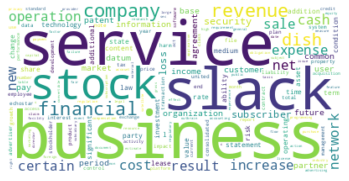

In [8]:
vocab = build_vocab('./input_data')
get_wordcloud(vocab)

500it [20:00,  2.40s/it]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 492/492 [18:15<00:00,  2.23s/it]


Wordcloud for Cyber Security


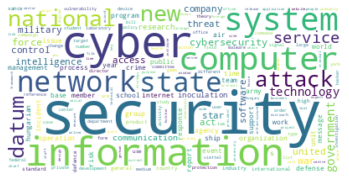

500it [31:32,  3.79s/it]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 422/422 [10:59<00:00,  1.56s/it]


Wordcloud for Fintech


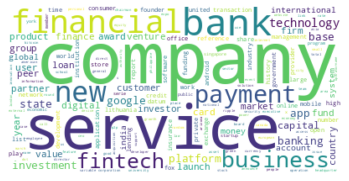

500it [47:45,  5.73s/it] 
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 453/453 [14:42<00:00,  1.95s/it]


Wordcloud for Cloud Computing


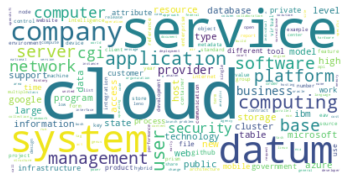

500it [30:07,  3.62s/it]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 439/439 [18:04<00:00,  2.47s/it]


Wordcloud for Virtual Reality and Gaming


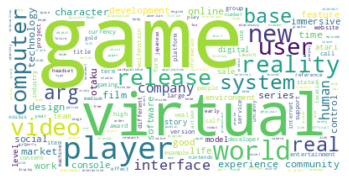

500it [32:12,  3.87s/it]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 470/470 [16:18<00:00,  2.08s/it]


Wordcloud for Robotics and Automation


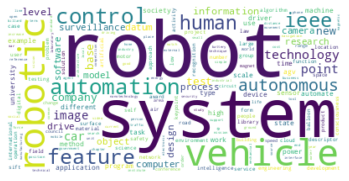

500it [29:36,  3.55s/it]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 462/462 [21:31<00:00,  2.80s/it]


Wordcloud for Artificial Intelligence Machine Learning


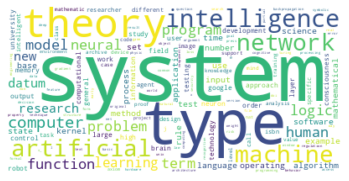

30it [01:25,  2.82s/it]

In [ ]:
# APPLYING IT FOR THE THEMES
theme_names = ['Cyber Security','Fintech','Cloud Computing','Virtual Reality and Gaming','Robotics and Automation','Artificial Intelligence Machine Learning']
for theme_name in (theme_names) :
    extract_data(theme_name)
    temp_name = theme_name.replace(' ','_') 
    vocab = build_vocab(f'./{temp_name}_data')
    print(f'Wordcloud for {theme_name}')
    get_wordcloud(vocab)
    save_vocab(vocab,temp_name)